# RQ2 — Modalidad de trabajo y salario (análisis ajustado)

**Pregunta de investigación (RQ2):**  
¿Se mantien una asociación entre la modalidad de trabajo (**In-person / Hybrid / Remote**) y el salario, una vez que ajustamos por variables observables como experiencia, educación, rol y país?

**Objetivo del análisis:**  
Estimar diferencias promedio condicionales en el salario (usando `log_salary`) entre modalidades de trabajo.  
Este análisis se interpreta como **asociación ajustada**, **no como efecto causal**, porque puede existir selección (p.ej., quién puede acceder a remoto) y factores no observados que también afectan salario.


In [ ]:
# Imports + Carga del dataset procesado + shape original
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import qqplot

from IPython.display import display

from statsmodels.stats.diagnostic import het_breuschpagan, het_white


# ---- Tablas cruzadas para ver soporte por país/rol vs modalidad ----
RW_HYB = "Hybrid (some remote, some in-person)"
RW_INP = "In-person"
RW_REM = "Remote"

DATA_PATH = "../data/processed/df_final_v1.csv"
df = pd.read_csv(DATA_PATH)

print("Shape original (processed):", df.shape)

df.columns


Shape original (processed): (65437, 21)


Index(['ResponseId', 'MainBranch', 'Employment', 'Country', 'RemoteWork',
       'ConvertedCompYearly', 'YearsCodePro', 'YearsCode', 'DevType',
       'EdLevel', 'Age', 'OrgSize', 'LanguageHaveWorkedWith',
       'DatabaseHaveWorkedWith', 'WebframeHaveWorkedWith',
       'PlatformHaveWorkedWith', 'ToolsTechHaveWorkedWith', 'has_salary',
       'log_salary', 'YearsCodePro_clean', 'YearsCodePro_num'],
      dtype='object')

In [128]:
# Filtro por has_salary (salario reportado)
df_rq2 = df[df["has_salary"]].copy()
print("Shape tras filtrar por los que reportaron salario:", df_rq2.shape)

# Para RQ2 necesitamos RemoteWork (modalidad). Creamos una versión sin NA en RemoteWork.
df_rq2 = df_rq2[df_rq2["RemoteWork"].notna()].copy()
print("Shape con salario y modalidad de trabajo no nulo:", df_rq2.shape)


Shape tras filtrar por los que reportaron salario: (23435, 21)
Shape con salario y modalidad de trabajo no nulo: (23427, 21)


In [129]:
# Diagnóstico de variables con muy pocos registros 

country_counts = df_rq2["Country"].value_counts()
print("\nPaíses menos frecuentes:")
display(country_counts.tail(10))

dev_counts = df_rq2["DevType"].value_counts()
print("\nRoles menos frecuentes:")
display(dev_counts.tail(10))

ed_counts = df_rq2["EdLevel"].value_counts()
print("\nNiveles educativos menos frecuentes:")
display(ed_counts.tail(10))

# Experiencia (YearsCodePro_num) es numérica: la binned para ver zonas con pocos casos ----
exp_bins = pd.cut(df_rq2["YearsCodePro_num"], bins=[-0.01, 0.5, 1, 3, 5, 10, 20, 30, 40, 60])
exp_bin_counts = exp_bins.value_counts().sort_index()
print("\nDistribución de experiencia (binned):")
display(exp_bin_counts)

ct_country = pd.crosstab(df_rq2["Country"], df_rq2["RemoteWork"])
for col in [RW_HYB, RW_INP, RW_REM]:
    if col not in ct_country.columns:
        ct_country[col] = 0
ct_country["total"] = ct_country[[RW_HYB, RW_INP, RW_REM]].sum(axis=1)
ct_country["n_modalities_present"] = (ct_country[[RW_HYB, RW_INP, RW_REM]] > 0).sum(axis=1)

print("\n¿Cuántos países tienen 1/2/3 modalidades presentes?")
display(ct_country["n_modalities_present"].value_counts().sort_index())



Países menos frecuentes:


Country
Oman                        1
Central African Republic    1
Samoa                       1
Antigua and Barbuda         1
Lesotho                     1
Brunei Darussalam           1
Burundi                     1
Barbados                    1
Mali                        1
Haiti                       1
Name: count, dtype: int64


Roles menos frecuentes:


DevType
Security professional              113
Educator                           108
Blockchain                          92
Developer Experience                88
Product manager                     87
Hardware Engineer                   65
Database administrator              59
Developer Advocate                  52
Designer                            44
Marketing or sales professional     17
Name: count, dtype: int64


Niveles educativos menos frecuentes:


EdLevel
Bachelor’s degree (B.A., B.S., B.Eng., etc.)                                          10363
Master’s degree (M.A., M.S., M.Eng., MBA, etc.)                                        6827
Some college/university study without earning a degree                                 2793
Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)     1184
Professional degree (JD, MD, Ph.D, Ed.D, etc.)                                         1155
Associate degree (A.A., A.S., etc.)                                                     749
Something else                                                                          209
Primary/elementary school                                                               147
Name: count, dtype: int64


Distribución de experiencia (binned):


YearsCodePro_num
(-0.01, 0.5]     657
(0.5, 1.0]       971
(1.0, 3.0]      3741
(3.0, 5.0]      3312
(5.0, 10.0]     6305
(10.0, 20.0]    5481
(20.0, 30.0]    2124
(30.0, 40.0]     622
(40.0, 60.0]     124
Name: count, dtype: int64


¿Cuántos países tienen 1/2/3 modalidades presentes?


n_modalities_present
1     25
2     27
3    114
Name: count, dtype: int64

### Análisis del caso de los países
Controlar por país implica que el modelo aprenderá un “nivel base” salarial para cada país.  
Si incluimos países con muy pocos registros o con ausencia de alguna modalidad (por ejemplo, 0 personas In-person), el modelo puede volverse **inestable** debido a que no hay suficiente información para separar “efecto país” vs “efecto modalidad”.

Por eso, antes de modelar, definimos un criterio de **soporte mínimo** por país:
- un mínimo de observaciones totales (`MIN_TOTAL`),
- un mínimo de observaciones **In-person** (`MIN_INPERSON`) para asegurar comparabilidad,
- y presencia de las 3 modalidades.


In [130]:
# Construcción del subdataset oficial (países “buenos” + columnas de interés)

MIN_TOTAL = 100
MIN_INPERSON = 20

ct_country_sorted = ct_country.sort_values("total", ascending=False)

good_countries = ct_country_sorted[
    (ct_country_sorted["total"] >= MIN_TOTAL) &
    (ct_country_sorted[RW_INP] >= MIN_INPERSON) &
    (ct_country_sorted["n_modalities_present"] == 3)
].index

cols_interest = [
    "Country", "RemoteWork", "EdLevel", "DevType",
    "YearsCodePro_num", "log_salary", "ConvertedCompYearly", "has_salary"
]

df_rq2_official = (
    df_rq2[df_rq2["Country"].isin(good_countries)]
    [cols_interest]
    .copy()
)

print("Países retenidos:", len(good_countries))
print("Filas antes:", len(df_rq2))
print("Filas después (subdataset oficial):", len(df_rq2_official))

df_rq2 = df_rq2_official


Países retenidos: 32
Filas antes: 23427
Filas después (subdataset oficial): 19932


In [131]:
df_tmp = df_rq2.copy()

# NO incluimos NaN como categoría de DevType para evitar problemas de indexado y rare_roles.
n_dev_nan = df_tmp["DevType"].isna().sum()
print(f"DevType NaN (faltantes): {n_dev_nan} ({n_dev_nan/len(df_tmp):.2%})")

# Conteos de roles no nulos
dev_counts = df_tmp.loc[df_tmp["DevType"].notna(), "DevType"].value_counts()

print("\nTop 10 roles más frecuentes:")
display(dev_counts.head(10))

print("\nBottom 15 roles menos frecuentes (sin NaN):")
display(dev_counts.tail(15))

ct_dev = pd.crosstab(df_tmp.loc[df_tmp["DevType"].notna(), "DevType"],
                     df_tmp.loc[df_tmp["DevType"].notna(), "RemoteWork"])

for col in [RW_HYB, RW_INP, RW_REM]:
    if col not in ct_dev.columns:
        ct_dev[col] = 0

ct_dev["total"] = ct_dev[[RW_HYB, RW_INP, RW_REM]].sum(axis=1)

# Porcentajes por rol (fila)
ct_dev_pct = ct_dev[[RW_HYB, RW_INP, RW_REM]].div(ct_dev["total"], axis=0)

# Selecciona roles raros (umbral ajustable)
MIN_DEVTYPE = 50
rare_roles = dev_counts[dev_counts < MIN_DEVTYPE].index.tolist()

print(f"\nUmbral de rareza = {MIN_DEVTYPE}")
print(f"Número de roles raros: {len(rare_roles)}")
print("Ejemplos de roles raros:", rare_roles[:5])

ct_rare = ct_dev.reindex(rare_roles).dropna(how="all").sort_values("total", ascending=True)

print("\nCrosstab (conteos) para roles raros:")
display(ct_rare[[RW_INP, RW_HYB, RW_REM, "total"]].head(20))

print("\nCrosstab (porcentajes por rol) para roles raros:")
display(ct_dev_pct.reindex(ct_rare.index).head(20))

df_rq2 = df_tmp


DevType NaN (faltantes): 28 (0.14%)

Top 10 roles más frecuentes:


DevType
Developer, full-stack                            6972
Developer, back-end                              3994
Developer, front-end                             1129
Developer, desktop or enterprise applications     923
Developer, embedded applications or devices       694
Developer, mobile                                 657
Other (please specify):                           574
Data engineer                                     497
Engineering manager                               465
DevOps specialist                                 427
Name: count, dtype: int64


Bottom 15 roles menos frecuentes (sin NaN):


DevType
System administrator               148
Student                            129
Scientist                          115
Engineer, site reliability         111
Project manager                    103
Security professional              103
Educator                           101
Developer Experience                77
Product manager                     70
Blockchain                          62
Hardware Engineer                   58
Database administrator              50
Developer Advocate                  48
Designer                            38
Marketing or sales professional     13
Name: count, dtype: int64


Umbral de rareza = 50
Número de roles raros: 3
Ejemplos de roles raros: ['Developer Advocate', 'Designer', 'Marketing or sales professional']

Crosstab (conteos) para roles raros:


RemoteWork,In-person,"Hybrid (some remote, some in-person)",Remote,total
DevType,,,,
Marketing or sales professional,3,8,2,13
Designer,9,17,12,38
Developer Advocate,3,11,34,48



Crosstab (porcentajes por rol) para roles raros:


RemoteWork,"Hybrid (some remote, some in-person)",In-person,Remote
DevType,,,
Marketing or sales professional,0.615385,0.230769,0.153846
Designer,0.447368,0.236842,0.315789
Developer Advocate,0.229167,0.062500,0.708333


In [132]:
df_rq2_devgroup = df_rq2.copy()

# Normalizar el "Other" existente directamente sobre una serie temporal
OTHER_RAW = "Other (please specify):"
OTHER_STD = "Other"

dev_series = df_rq2_devgroup["DevType"].replace({OTHER_RAW: OTHER_STD})

# Definir rare_roles sobre DevType no nulo (ya normalizado)
dev_counts = dev_series.dropna().value_counts()
rare_roles = set(dev_counts[dev_counts < MIN_DEVTYPE].index)
rare_roles.discard(OTHER_STD)  # no “mandar Other a Other” por conteo

# Crear DevType agrupado y quedarnos solo con ese como columna final "DevType"
df_rq2_devgroup["DevType"] = dev_series.where(~dev_series.isin(rare_roles), other=OTHER_STD)

# recodificación NO debería cambiar filas
print("\nShape antes (df_tmp):", df_tmp.shape)
print("Shape después de recodificar (sin filtrar NaN):", df_rq2_devgroup.shape)
lost_by_recode = df_tmp.shape[0] - df_rq2_devgroup.shape[0]
print(f"Filas perdidas por recodificación: {lost_by_recode} (esperado: 0)")

# filtrar por DevType no nulo 
before_dropna = df_rq2_devgroup.shape[0]
df_rq2_devgroup = df_rq2_devgroup[df_rq2_devgroup["DevType"].notna()].copy()
after_dropna = df_rq2_devgroup.shape[0]
lost_by_dropna = before_dropna - after_dropna

print(f"\nFilas perdidas por filtrar DevType no nulo: {lost_by_dropna} "
      f"({lost_by_dropna/before_dropna:.2%} de la muestra previa al filtro)")

# ¿Cuántos quedaron en Other?
n_other = (df_rq2_devgroup["DevType"] == OTHER_STD).sum()
print(f"\nObservaciones en '{OTHER_STD}': {n_other} ({n_other/len(df_rq2_devgroup):.2%} de la muestra final)")

# Crosstab DevType × RemoteWork (conteos) para ver soporte final (incluye Other)
ct_group = pd.crosstab(df_rq2_devgroup["DevType"], df_rq2_devgroup["RemoteWork"])
for col in [RW_HYB, RW_INP, RW_REM]:
    if col not in ct_group.columns:
        ct_group[col] = 0
ct_group["total"] = ct_group[[RW_HYB, RW_INP, RW_REM]].sum(axis=1)

print("\nCrosstab DevType × RemoteWork (conteos) [DevType ya agrupado]:")
display(ct_group.sort_values("total", ascending=True).head(20))

df_rq2 = df_rq2_devgroup



Shape antes (df_tmp): (19932, 8)
Shape después de recodificar (sin filtrar NaN): (19932, 8)
Filas perdidas por recodificación: 0 (esperado: 0)

Filas perdidas por filtrar DevType no nulo: 28 (0.14% de la muestra previa al filtro)

Observaciones en 'Other': 673 (3.38% de la muestra final)

Crosstab DevType × RemoteWork (conteos) [DevType ya agrupado]:


RemoteWork,"Hybrid (some remote, some in-person)",In-person,Remote,total
DevType,,,,
Database administrator,17,10,23,50
Hardware Engineer,28,26,4,58
Blockchain,10,4,48,62
Product manager,35,16,19,70
Developer Experience,28,6,43,77
Educator,37,41,23,101
Project manager,47,23,33,103
Security professional,42,8,53,103
"Engineer, site reliability",47,14,50,111


## Análisis de el caso `DevType` (roles raros + categoría “Other” existente)

Al inspeccionar `DevType` se observa una distribución muy desbalanceada: algunos roles tienen miles de observaciones, mientras que otros aparecen con **muy pocos casos** (por ejemplo, *Marketing or sales professional* con 17). Esto importa por dos razones:

1. **Dummies muy escasas ⇒ estimaciones inestables.**  
   Un rol con muy pocas observaciones genera coeficientes y errores estándar altamente ruidosos. En ese contexto, la “no significancia” de una dummy individual suele reflejar **falta de soporte**, no necesariamente ausencia de relación.

2. **Celdas raras pueden inducir leverage/influencia.**  
   En modelos con múltiples variables categóricas (educación, rol, país), categorías raras aumentan el riesgo de combinaciones poco frecuentes, lo que puede producir observaciones con leverage alto y volver más frágil la inferencia.

### ¿Por qué no filtramos (eliminamos) observaciones por `DevType`?
A diferencia del filtrado por `Country` (que se justifica por **soporte e identificación** al comparar modalidades dentro de país cuando se usan efectos fijos), filtrar por rol implicaría **eliminar personas** y podría introducir sesgos si esos roles tienen perfiles distintos (salario, experiencia, modalidad).

### Decisión: agrupar roles raros dentro de “Other”
El dataset ya incluye una categoría `Other (please specify):`. Para evitar crear una etiqueta adicional y mantener interpretabilidad:

- Renombramos `Other (please specify):` a **`Other`**.
- Reagrupamos roles con baja frecuencia (bajo un umbral `MIN_DEVTYPE`) dentro de **`Other`**.

Esto mejora la **estabilidad del diseño** (menos dummies extremadamente escasas) sin perder tamaño muestral por la recodificación.  
Finalmente, reportamos cuántas observaciones quedan como `Other` y cuántas permanecen como `NaN` en `DevType` para cuantificar la pérdida potencial **solo si** más adelante se decide hacer `dropna` sobre esta variable.


In [133]:
# Shape del subdataset oficial + distribución de RemoteWork

print("Shape subdataset oficial:", df_rq2.shape)

print("\nDistribución de RemoteWork (subdataset oficial):")
display(df_rq2["RemoteWork"].value_counts())

print("\n% por modalidad:")
display((df_rq2["RemoteWork"].value_counts(normalize=True)*100).round(2))


Shape subdataset oficial: (19904, 8)

Distribución de RemoteWork (subdataset oficial):


RemoteWork
Hybrid (some remote, some in-person)    8616
Remote                                  8138
In-person                               3150
Name: count, dtype: int64


% por modalidad:


RemoteWork
Hybrid (some remote, some in-person)    43.29
Remote                                  40.89
In-person                               15.83
Name: proportion, dtype: float64

## Consideración sobre desbalance entre modalidades de trabajo

La distribución muestral por modalidad evidencia un **desbalance** (con menor proporción de observaciones en **In-person** respecto de **Remote** y **Hybrid**). Este punto es relevante por tres razones:

1) **Precisión de la estimación**: un tamaño de muestra menor en el grupo de referencia (o en cualquier grupo) suele incrementar la varianza de los estimadores asociados a comparaciones entre grupos, lo que se refleja en **errores estándar más altos** y, por tanto, en intervalos de confianza más amplios.

2) **Soporte dentro de subgrupos (Country × RemoteWork)**: aun cuando el filtrado por país garantiza presencia mínima de modalidades, el desbalance puede persistir a nivel de país u otras particiones relevantes, generando **celdas con baja frecuencia**. Esto puede afectar la estabilidad numérica del ajuste al incorporar múltiples variables categóricas (educación, rol, país), y aumentar la probabilidad de observaciones con **alto leverage**.

3) **Implicaciones para inferencia**: en contextos con desbalance y combinación de categorías, es común observar **heterocedasticidad** y/o sensibilidad a observaciones influyentes. Por ello, es apropiado complementar el modelado con diagnósticos formales de supuestos y, de ser necesario, utilizar estimadores de varianza robustos para asegurar inferencia confiable.

En las secciones siguientes se verificará el soporte efectivo del subdataset utilizado para estimación y se evaluarán supuestos e influencia antes de fijar la estrategia de errores estándar.



In [ ]:
# === Diagnóstico para justificar errores estándar robustos (y la elección de HC3) ===



# Dataset final que entra al modelo (post-dropna en variables del modelo)
model_cols = ["Country", "RemoteWork", "EdLevel", "DevType", "YearsCodePro_num", "log_salary"]
df_rq2_model = df_rq2.dropna(subset=model_cols).copy()

print("Dataset para modelar (post-dropna):", df_rq2_model.shape)


# 2) Modelo "diagnóstico" (clásico, sin robust) sobre el cual evaluamos supuestos
#    Nota: usamos Treatment con referencia In-person para interpretabilidad.
rw_term = f"C(RemoteWork, Treatment(reference='{RW_INP}'))"
formula_diag = f"log_salary ~ {rw_term} + YearsCodePro_num + C(EdLevel) + C(DevType)"

m_diag = smf.ols(formula_diag, data=df_rq2_model).fit()

print("\n=== Modelo diagnóstico (SE clásicos) ===")
print("Fórmula:", formula_diag)
print(f"n = {int(m_diag.nobs)}, parámetros (incl. intercepto) ~ {int(m_diag.df_model) + 1}")

# 3) Pruebas formales de heterocedasticidad (sobre residuos del modelo diagnóstico)
#    H0 (BP): varianza constante condicional a X
#    H0 (White): varianza constante sin especificar forma (más general)
exog = m_diag.model.exog
resid = m_diag.resid

bp_lm, bp_lm_pvalue, bp_f, bp_f_pvalue = het_breuschpagan(resid, exog)
w_lm, w_lm_pvalue, w_f, w_f_pvalue = het_white(resid, exog)

het_table = pd.DataFrame(
    {
        "Test": ["Breusch–Pagan (LM)", "Breusch–Pagan (F)", "White (LM)", "White (F)"],
        "Stat": [bp_lm, bp_f, w_lm, w_f],
        "p-value": [bp_lm_pvalue, bp_f_pvalue, w_lm_pvalue, w_f_pvalue],
    }
)

print("\n=== Tests de heterocedasticidad (sobre el modelo diagnóstico) ===")
display(het_table)

# 4) Diagnóstico de leverage e influencia (para justificar HC3 vs HC0/HC1)
infl = m_diag.get_influence()
hat = infl.hat_matrix_diag                       # leverage h_ii
cooks = infl.cooks_distance[0]                   # Cook's distance
rstud = infl.resid_studentized_internal          # residuos studentizados

n = int(m_diag.nobs)
p = int(m_diag.df_model) + 1                     # parámetros incl. intercepto

thr_2 = 2 * p / n
thr_3 = 3 * p / n
thr_cook = 4 / n

leverage_summary = pd.DataFrame({
    "n": [n],
    "p_params": [p],
    "mean(h_ii)": [hat.mean()],
    "max(h_ii)": [hat.max()],
    "thr_high_lev_2p/n": [thr_2],
    "thr_high_lev_3p/n": [thr_3],
    "share(h_ii > 2p/n)": [(hat > thr_2).mean()],
    "share(h_ii > 3p/n)": [(hat > thr_3).mean()],
    "share(|rstudent| > 3)": [(np.abs(rstud) > 3).mean()],
    "share(CookD > 4/n)": [(cooks > thr_cook).mean()],
})

print("\n=== Diagnóstico de leverage / influencia (modelo diagnóstico) ===")
display(leverage_summary)

# Mostrar las observaciones más influyentes (útil para discusión académica)
top_k = 10
top_influence = pd.DataFrame({
    "hat(h_ii)": hat,
    "CookD": cooks,
    "rstudent": rstud,
    "RemoteWork": df_rq2_model["RemoteWork"].values,
    "Country": df_rq2_model["Country"].values,
    "DevType": df_rq2_model["DevType"].values,
    "EdLevel": df_rq2_model["EdLevel"].values,
    "YearsCodePro_num": df_rq2_model["YearsCodePro_num"].values,
}).sort_values("CookD", ascending=False).head(top_k)

print(f"\nTop {top_k} observaciones por Cook's distance (potencial influencia):")
display(top_influence)

# 5) Comparación de inferencia para los coeficientes de RemoteWork: Clásico vs HC0–HC3
rw_coefs = [k for k in m_diag.params.index if "RemoteWork" in k]
if len(rw_coefs) == 0:
    print("\n[Advertencia] No se encontraron coeficientes de RemoteWork en el modelo. Revisa categorías o fórmula.")
else:
    def extract_coef_table(res, label):
        # Robust results can return numpy arrays; align by parameter names first.
        param_names = list(getattr(getattr(res, "model", None), "exog_names", []) or [])
        if not param_names and hasattr(res.params, "index"):
            param_names = list(res.params.index)
        if not param_names:
            param_names = list(range(len(res.params)))

        if hasattr(res.params, "index"):
            params = res.params
            bse = res.bse
            tvalues = res.tvalues
            pvalues = res.pvalues
        else:
            params = pd.Series(res.params, index=param_names)
            bse = pd.Series(res.bse, index=param_names)
            tvalues = pd.Series(res.tvalues, index=param_names)
            pvalues = pd.Series(res.pvalues, index=param_names)

        out = pd.DataFrame({
            "coef": params.loc[rw_coefs],
            "se": bse.loc[rw_coefs],
            "t": tvalues.loc[rw_coefs],
            "p": pvalues.loc[rw_coefs],
        })
        out["cov_type"] = label
        return out.reset_index().rename(columns={"index": "term"})

    tables = [extract_coef_table(m_diag, "Classical")]
    for cov in ["HC0", "HC1", "HC2", "HC3"]:
        tables.append(extract_coef_table(m_diag.get_robustcov_results(cov_type=cov), cov))

    se_compare = pd.concat(tables, ignore_index=True)

    # Pivot para comparar SE de forma clara
    se_pivot = se_compare.pivot_table(index="term", columns="cov_type", values="se")
    se_pivot["HC3/HC1"] = se_pivot["HC3"] / se_pivot["HC1"]
    se_pivot["HC3/Classical"] = se_pivot["HC3"] / se_pivot["Classical"]

    print("\n=== Comparación de errores estándar (coeficientes RemoteWork) ===")
    display(se_pivot)

    # Resumen final en texto (para que la celda “hable” sola)
    print("\n=== Resumen automático para justificar HC3 ===")
    print("- Si BP/White muestran p-values pequeños, existe evidencia de heterocedasticidad → SE clásicos no confiables.")
    print("- Si hay una fracción no despreciable de h_ii > 2p/n o CookD > 4/n, hay leverage/influencia → conviene corrección tipo HC3.")
    print("- Si HC3/HC1 > 1 en términos clave, HC3 está siendo más conservador (especialmente relevante con dummies y celdas raras).")


Dataset para modelar (post-dropna): (19839, 8)

=== Modelo diagnóstico (SE clásicos) ===
Fórmula: log_salary ~ C(RemoteWork, Treatment(reference='In-person')) + YearsCodePro_num + C(EdLevel) + C(DevType)
n = 19839, parámetros (incl. intercepto) ~ 41

=== Tests de heterocedasticidad (sobre el modelo diagnóstico) ===


,Test,Stat,p-value
0,Breusch–Pagan (LM),294.066556,1.993699e-40
1,Breusch–Pagan (F),7.446853,8.811968e-41
2,White (LM),833.962572,2.000858e-43
3,White (F),2.516454,8.340196e-45



=== Diagnóstico de leverage / influencia (modelo diagnóstico) ===


,n,p_params,mean(h_ii),max(h_ii),thr_high_lev_2p/n,thr_high_lev_3p/n,share(h_ii > 2p/n),share(h_ii > 3p/n),share(|rstudent| > 3),share(CookD > 4/n)
0,19839,41,0.002067,0.024238,0.004133,0.0062,0.127123,0.077524,0.021271,0.044004



Top 10 observaciones por Cook's distance (potencial influencia):


,hat(h_ii),CookD,rstudent,RemoteWork,Country,DevType,EdLevel,YearsCodePro_num
16825,0.009886,0.019375,-8.919734,"Hybrid (some remote, some in-person)",Indonesia,Security professional,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",15.0
5540,0.014518,0.012712,-5.947889,In-person,India,Data or business analyst,Primary/elementary school,2.0
593,0.007110,0.010306,-7.681815,"Hybrid (some remote, some in-person)",United States of America,"Developer, game or graphics","Associate degree (A.A., A.S., etc.)",11.0
15223,0.005901,0.010279,-8.425793,"Hybrid (some remote, some in-person)",United States of America,Data or business analyst,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",2.0
9516,0.007125,0.009853,-7.502706,In-person,United States of America,System administrator,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",20.0
7629,0.008289,0.007731,-6.158161,Remote,India,Student,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",1.0
3292,0.008240,0.007407,-6.045545,Remote,Australia,System administrator,"Professional degree (JD, MD, Ph.D, Ed.D, etc.)",35.0
13468,0.009804,0.007165,-5.446899,Remote,Ukraine,"Developer, desktop or enterprise applications",Primary/elementary school,3.0
5382,0.008823,0.006022,-5.266671,Remote,Ukraine,"Developer, back-end",Primary/elementary school,6.0
15002,0.006819,0.005866,-5.918467,"Hybrid (some remote, some in-person)",Israel,Data or business analyst,"Professional degree (JD, MD, Ph.D, Ed.D, etc.)",3.0



=== Comparación de errores estándar (coeficientes RemoteWork) ===


cov_type,Classical,HC0,HC1,HC2,HC3,HC3/HC1,HC3/Classical
term,,,,,,,
"C(RemoteWork, Treatment(reference='In-person'))[T.Hybrid (some remote, some in-person)]",0.024930,0.025373,0.025399,0.025404,0.025436,1.001477,1.020320
"C(RemoteWork, Treatment(reference='In-person'))[T.Remote]",0.025639,0.027786,0.027815,0.027819,0.027852,1.001318,1.086313



=== Resumen automático para justificar HC3 ===
- Si BP/White muestran p-values pequeños, existe evidencia de heterocedasticidad → SE clásicos no confiables.
- Si hay una fracción no despreciable de h_ii > 2p/n o CookD > 4/n, hay leverage/influencia → conviene corrección tipo HC3.
- Si HC3/HC1 > 1 en términos clave, HC3 está siendo más conservador (especialmente relevante con dummies y celdas raras).


## Justificación de errores estándar robustos y elección de HC3 (con evidencia empírica)

En OLS, la inferencia clásica (errores estándar no robustos) depende críticamente del supuesto de **homocedasticidad condicional**, es decir, varianza constante del término de error dado el conjunto de covariables. Para evaluar este supuesto (y la estabilidad del ajuste), se estimó un **modelo diagnóstico** con la siguiente especificación:

$
\log(\text{salary}) \sim \text{RemoteWork} + \text{YearsCodePro} + C(\text{EdLevel}) + C(\text{DevType})
$

con $n = 19{,}839$ observaciones y $p = 41$ parámetros (incluyendo intercepto).

### 1) Evidencia formal de heterocedasticidad
Se aplicaron pruebas estándar sobre los residuos del modelo diagnóstico:

- **Breusch–Pagan (LM):** $p = 1.99\times10^{-40}$  
- **Breusch–Pagan (F):** $p = 8.81\times10^{-41}$  
- **White (LM):** $p = 2.00\times10^{-43}$  
- **White (F):** $p = 8.34\times10^{-45}$

En todos los casos, los p-values son extremadamente pequeños, por lo que se **rechaza** la hipótesis nula de homocedasticidad. Esto implica que los **errores estándar clásicos son inconsistentes** bajo esta evidencia, y por tanto los t-tests e intervalos de confianza basados en ellos pueden ser engañosos. En consecuencia, la inferencia debe basarse en estimadores de varianza **robustos a heterocedasticidad**.

### 2) Evidencia de leverage / influencia (relevante para escoger HC3)
Además, se evaluó la estructura de leverage e influencia:

- Promedio de leverage: $\overline{h_{ii}} = 0.002067$ (consistente con $p/n$)  
- Máximo de leverage: $\max(h_{ii}) = 0.024238$  
- Umbrales heurísticos:
  - $2p/n = 0.004133$
  - $3p/n = 0.0062$
- Proporciones:
  - $\Pr(h_{ii} > 2p/n) = 12.7\%$
  - $\Pr(h_{ii} > 3p/n) = 7.75\%$
  - $\Pr(|r_{\text{student}}| > 3) = 2.13\%$
  - $\Pr(\text{CookD} > 4/n) = 4.40\%$

Estos resultados son consistentes con un diseño que incluye múltiples variables categóricas (dummies), donde algunas combinaciones pueden ser raras y generar **observaciones con leverage relativamente alto**. En este contexto, es razonable preferir un estimador robusto que sea más conservador frente a leverage.

### 3) Comparación práctica: SE clásicos vs HC0–HC3 en los coeficientes clave (RemoteWork)
La evidencia empírica muestra que los errores estándar robustos pueden ser mayores que los clásicos, particularmente para el término **Remote**:

- Para **Hybrid**: $SE_{HC3} / SE_{\text{clásico}} \approx 1.02$ (+2.0%)  
- Para **Remote**: $SE_{HC3} / SE_{\text{clásico}} \approx 1.086$ (+8.6%)

Esto confirma que la heterocedasticidad afecta materialmente la inferencia (sobre todo para Remote), y que usar SE clásicos sería optimista.

Entre robustos, la diferencia entre **HC3 y HC1** en los términos de RemoteWork es pequeña:

- $SE_{HC3} / SE_{HC1} \approx 1.0013$–$1.0015$

Lo anterior sugiere que, para los coeficientes de interés, la inferencia es **estable** dentro de la familia HC. Aun así, se adopta **HC3 como especificación principal** por ser más conservador frente a leverage y por ser una elección estándar recomendable cuando existen señales de observaciones con leverage no trivial en un modelo con dummies.

**Conclusión:** Dado que (i) se rechaza contundentemente homocedasticidad y (ii) hay evidencia de leverage/influencia, se reportan resultados con **errores estándar robustos**, utilizando **HC3** como estrategia principal de inferencia, y se reconoce que los resultados para los coeficientes clave son consistentes frente a otras variantes HC.


## Transformación de salario (`log_salary`) y elección de OLS

### (i) Motivación de `log_salary`
En análisis anteriores vimos que los salarios presentan **asimetría positiva** y mecanismos de variación más cercanos a efectos **multiplicativos** (porcentajes) que aditivos. La transformación logarítmica se utiliza porque:

1) **Reduce asimetría y atenúa valores extremos**, facilitando relaciones aproximadamente lineales con covariables.  
2) Permite una **interpretación económica natural**: en un modelo log-lineal, los coeficientes se interpretan como diferencias porcentuales aproximadas. Para una dummy con coeficiente $\beta$, el efecto exacto se expresa como:

$
100\cdot(\exp(\beta)-1)\%
$

Esta interpretación es especialmente útil para comparar modalidades de trabajo (Remote/Hybrid/In-person) en términos relativos.

**Nota:** La transformación logarítmica, aunque estabiliza parcialmente la varianza, hemos visto que no garantiza homocedasticidad, lo cual refuerza la necesidad de errores estándar robustos.

### (ii) Por qué OLS
Se utiliza OLS para estimar **diferencias promedio condicionales** en $\log(\text{salary})$ entre modalidades, controlando por experiencia, educación y rol (y posteriormente, en modelos ampliados, por país). En términos de expectativa condicional:

$
E[\log(\text{salary})\mid X] = X\beta
$

El objetivo es cuantificar asociaciones ajustadas entre modalidad y salario, manteniendo constantes covariables observables. Este enfoque **no se interpreta como causal**: pueden persistir fuentes de selección (p.ej., industria/empresa, seniority no capturado completamente, o auto-selección a remoto). Por ello, el análisis se reporta como **asociación ajustada**, complementado con diagnósticos y estrategia de inferencia robusta.


## Modelos (M0–M3)

El objetivo es estimar la asociación entre modalidad de trabajo y salario (en escala logarítmica), construyendo el modelo de forma incremental para evaluar **estabilidad** de los coeficientes de interés y reducir potencial **confusión** por variables observables. En particular, se estima una secuencia de modelos anidados donde cada bloque añadido controla por dimensiones relevantes de composición muestral:

- **M0 (asociación cruda):** captura diferencias promedio sin controles.
- **M1 (+ experiencia):** incorpora $\text{YearsCodePro}$, dado que la modalidad de trabajo está fuertemente relacionada con experiencia.
- **M2 (+ educación y rol):** añade $C(\text{EdLevel})$ y $C(\text{DevType})$ para ajustar por diferencias sistemáticas en formación y ocupación.
- **M3 (+ país):** añade $C(\text{Country})$ para comparar modalidades **dentro de país**, controlando heterogeneidad entre mercados laborales nacionales.

En todos los modelos se reportan **errores estándar robustos HC3**, conforme a la evidencia diagnóstica de heterocedasticidad y a la presencia de leverage/influencia no trivial en un diseño con múltiples variables categóricas.


In [136]:
# Función para resumir solo el efecto de RemoteWork
def remote_effects(model):
    coefs = model.params.filter(like="RemoteWork")
    ci = model.conf_int().loc[coefs.index]
    out = pd.DataFrame({
        "beta_log": coefs,
        "pct_effect": 100*(np.exp(coefs)-1),
        "ci_low_pct": 100*(np.exp(ci[0])-1),
        "ci_high_pct": 100*(np.exp(ci[1])-1),
        "p_value": model.pvalues.loc[coefs.index]
    })
    return out

In [137]:
# Modelo M0 + tabla remote_effects
import statsmodels.formula.api as smf

RW_INP = "In-person"
rw_term = f'C(RemoteWork, Treatment(reference="{RW_INP}"))'

m0 = smf.ols(
    f"log_salary ~ {rw_term}",
    data=df_rq2_model
).fit(cov_type="HC3")


print(m0.summary())
display(remote_effects(m0))


                            OLS Regression Results                            
Dep. Variable:             log_salary   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     156.6
Date:                Sat, 10 Jan 2026   Prob (F-statistic):           3.27e-68
Time:                        23:03:55   Log-Likelihood:                -32880.
No. Observations:               19839   AIC:                         6.577e+04
Df Residuals:                   19836   BIC:                         6.579e+04
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                                                                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

,beta_log,pct_effect,ci_low_pct,ci_high_pct,p_value
"C(RemoteWork, Treatment(reference=""In-person""))[T.Hybrid (some remote, some in-person)]",0.464997,59.200976,50.955351,67.897000,7.922359e-66
"C(RemoteWork, Treatment(reference=""In-person""))[T.Remote]",0.459535,58.333799,49.612751,67.563203,6.599653e-57


### Análisis de M0 (modelo crudo)

En **M0** la única variable explicativa es `RemoteWork`, usando **In-person** como categoría de referencia.
Este modelo sirve como **línea base**: cuantifica la diferencia promedio de salario entre modalidades **sin** controlar por país, experiencia, educación o rol.

---

#### Interpretación de los coeficientes (Hybrid/Remote vs In-person)

El modelo tiene la forma:


$$
\begin{aligned}
\mathrm{log\_salary} &= \beta_0 + \beta_H \, \mathbb{1}(\mathrm{Hybrid}) + \beta_R \, \mathbb{1}(\mathrm{Remote}) + \varepsilon
\end{aligned}
$$


- **Intercept (β₀ = 10.5305)**: representa el **promedio de `log_salary`** para el grupo **In-person** (categoría base).
- **βH (Hybrid vs In-person = 0.4650)**: diferencia promedio en `log_salary` entre **Hybrid** e **In-person**.
- **βR (Remote vs In-person = 0.4595)**: diferencia promedio en `log_salary` entre **Remote** e **In-person**.

Como `log_salary = log(1 + salario)`, es más interpretable expresar los coeficientes como cambios porcentuales aproximados:

$$
\%\Delta \approx 100 \, (e^{\beta} - 1)
$$

Con tus resultados (`remote_effects(M0)`):

- **Hybrid vs In-person**:  
  - β = **0.464997** → **+59.20%**  
  - IC95%: **[+50.96%, +67.90%]**  
  - p-value: **7.92e-66**
- **Remote vs In-person**:  
  - β = **0.459535** → **+58.33%**  
  - IC95%: **[+49.61%, +67.56%]**  
  - p-value: **6.60e-57**

En el análisis crudo, **Hybrid y Remote se asocian con salarios ~58-59% mayores** que In-person (en promedio), y la evidencia estadística es muy fuerte (p-values extremadamente pequeños).

Un detalle adicional: los coeficientes de **Hybrid** y **Remote** son casi iguales en M0 (≈0.465 vs ≈0.460), lo que sugiere que en la muestra cruda ambos grupos tienen un nivel promedio de `log_salary` **muy similar** entre sí, y ambos están por encima de In-person.

---

Este modelo es **unadjusted**: no incluye controles por `Country`, `YearsCodePro_num`, `EdLevel` ni `DevType`.  
Por tanto,aun no podemos concluir que el trabajo remoto/híbrido **cause** un mayor salario ya que la diferencia puede estar parcialmente explicada por **confusión** (p. ej., distintos países, distintos roles, distinta experiencia).

Esto también se refleja en el **R² = 0.017**: `RemoteWork` por sí sola explica una parte pequeña de la variabilidad del salario, lo cual es esperable en datos salariales (hay muchos factores adicionales relevantes).

> En resumen: M0 es el “antes de ajustar”. Útil para tener un punto de partida, pero todavía no responde RQ2.


In [138]:
# Modelo M1 (añadiendo experiencia) + remote_effects
m1 = smf.ols(
    f"log_salary ~ {rw_term} + YearsCodePro_num",
    data=df_rq2_model
).fit(cov_type="HC3")

print(m1.summary())
display(remote_effects(m1))

                            OLS Regression Results                            
Dep. Variable:             log_salary   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     1025.
Date:                Sat, 10 Jan 2026   Prob (F-statistic):               0.00
Time:                        23:03:55   Log-Likelihood:                -31749.
No. Observations:               19839   AIC:                         6.351e+04
Df Residuals:                   19835   BIC:                         6.354e+04
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                                                                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

,beta_log,pct_effect,ci_low_pct,ci_high_pct,p_value
"C(RemoteWork, Treatment(reference=""In-person""))[T.Hybrid (some remote, some in-person)]",0.375870,45.625778,38.503175,53.114666,7.398372e-49
"C(RemoteWork, Treatment(reference=""In-person""))[T.Remote]",0.289351,33.556059,26.523989,40.978963,1.014311e-25


### Análisis de M1

En **M1** extendemos el modelo crudo (M0) añadiendo **experiencia profesional** (`YearsCodePro_num`) como covariable numérica. La especificación es:

$$
\mathrm{log\_salary} \sim \mathrm{RemoteWork} + \mathrm{YearsCodePro\_num}
$$

donde se mantiene `RemoteWork` como variable categórica con **In-person** como referencia.

---

#### ¿Cuánto cambia el efecto de RemoteWork al controlar por experiencia?

Comparando M0 (sin controles) con M1 (controlando por experiencia), el “premium” asociado a `RemoteWork` se reduce de forma clara:

- **Hybrid vs In-person**
  - M0: **+59.20%** (IC95%: 50.96%–67.90%)
  - M1: **+45.63%** (IC95%: 38.50%–53.11%)

- **Remote vs In-person**
  - M0: **+58.33%** (IC95%: 49.61%–67.56%)
  - M1: **+33.56%** (IC95%: 26.52%–40.98%)

**Interpretación:** al incluir experiencia, parte de la diferencia cruda entre modalidades se “absorbe” por `YearsCodePro_num`. Esto indica que los grupos (Remote/Hybrid/In-person) no tienen la misma distribución de experiencia y que la experiencia está correlacionada con el salario. En otras palabras, una fracción del efecto observado en M0 era **confusión por experiencia**.

Aun así, en M1 los efectos de `RemoteWork` permanecen:
- **positivos**,
- con **IC95% completamente por encima de 0**, y
- con **p-values extremadamente pequeños**,

lo que sugiere que incluso comparando personas con niveles similares de experiencia (en promedio), `RemoteWork` sigue asociado a mayores salarios respecto a In-person.

---

#### Interpretación del coeficiente de `YearsCodePro_num`

En el `summary()` de M1, el coeficiente estimado para `YearsCodePro_num` es:

- **β = 0.0479** (en escala `log_salary`), con p ≪ 0.001.

Como la variable dependiente está en log, el coeficiente se interpreta (aproximadamente) como un cambio porcentual por cada año adicional de experiencia:

$$
\%\Delta \approx 100 \, (e^{0.0479} - 1)
$$

$$
e^{0.0479} \approx 1.049 \Rightarrow \%\Delta \approx 4.9\%
$$

**Lectura:** manteniendo constante la modalidad de trabajo, **un año adicional de experiencia profesional** se asocia con un incremento aproximado de **~4.7%** en el salario (en promedio), bajo este modelo.


---

#### Comentario sobre ajuste global

En M1, **R² ≈ 0.123**, lo que representa un aumento sustancial frente a M0 (R² ≈ 0.017). Esto es esperable: la experiencia explica una porción relevante de la variación salarial y mejora notablemente el ajuste del modelo, incluso sin incorporar todavía educación, rol y país.

---

#### Conclusión parcial 

M1 muestra que **controlar por experiencia reduce** el efecto crudo de `RemoteWork`, especialmente para la categoría **Remote**, pero no lo elimina. El siguiente paso (M2) evaluará si educación y rol explican parte adicional del efecto; finalmente, M3 incorporará país, que suele ser un confusor clave en salarios.


In [139]:
# Modelo M2 (experiencia + educación + rol) + remote_effects
m2 = smf.ols(
    f"log_salary ~ {rw_term} + YearsCodePro_num + C(EdLevel) + C(DevType)",
    data=df_rq2_model
).fit(cov_type="HC3")

print(m2.summary())
display(remote_effects(m2))


                            OLS Regression Results                            
Dep. Variable:             log_salary   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     97.08
Date:                Sat, 10 Jan 2026   Prob (F-statistic):               0.00
Time:                        23:03:55   Log-Likelihood:                -31404.
No. Observations:               19839   AIC:                         6.289e+04
Df Residuals:                   19798   BIC:                         6.321e+04
Df Model:                          40                                         
Covariance Type:                  HC3                                         
                                                                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

,beta_log,pct_effect,ci_low_pct,ci_high_pct,p_value
"C(RemoteWork, Treatment(reference=""In-person""))[T.Hybrid (some remote, some in-person)]",0.362414,43.67931,36.691878,51.023927,4.624879e-46
"C(RemoteWork, Treatment(reference=""In-person""))[T.Remote]",0.288967,33.50476,26.412310,40.995137,3.215013e-25


### Análisis de M2 

En **M2** se amplía M1 incorporando dos bloques de covariables categóricas: **educación** (`EdLevel`) y **rol** (`DevType`). Se incluyen como conjuntos de indicadores (dummies), manteniendo **In-person** como referencia para `RemoteWork`. La especificación es:

$$
\mathrm{log\_salary} \sim \mathrm{RemoteWork} + \mathrm{YearsCodePro\_num} + C(\mathrm{EdLevel}) + C(\mathrm{DevType})
$$

---

#### Efectos parciales de `RemoteWork` (M1 → M2)

Comparando M1 con M2, los diferenciales asociados a `RemoteWork` se mantienen muy estables:

- **Hybrid vs In-person**
  - M1: **+45.63%** (IC95%: 38.50%–53.11%)
  - M2: **+43.68%** (IC95%: 36.69%–51.02%)

- **Remote vs In-person**
  - M1: **+33.56%** (IC95%: 26.52%–40.98%)
  - M2: **+33.50%** (IC95%: 26.41%–41.00%)

Los IC95% permanecen por encima de 0 y la evidencia sigue siendo muy fuerte (p-values: **4.62e-46** y **3.22e-25**). La diferencia respecto a M1 es muy pequeña, lo que indica que **educación y rol no actúan como confusores relevantes** de la asociación entre modalidad de trabajo y salario en este modelo (su inclusión apenas altera los coeficientes de `RemoteWork`).


In [140]:
# Modelo M3 (final: + país) + remote_effects
m3 = smf.ols(
    f"log_salary ~ {rw_term} + YearsCodePro_num + C(EdLevel) + C(DevType) + C(Country)",
    data=df_rq2_model
).fit(cov_type="HC3")

print(m3.summary())
display(remote_effects(m3))


                            OLS Regression Results                            
Dep. Variable:             log_salary   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     203.8
Date:                Sat, 10 Jan 2026   Prob (F-statistic):               0.00
Time:                        23:03:56   Log-Likelihood:                -26860.
No. Observations:               19839   AIC:                         5.386e+04
Df Residuals:                   19767   BIC:                         5.443e+04
Df Model:                          71                                         
Covariance Type:                  HC3                                         
                                                                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

,beta_log,pct_effect,ci_low_pct,ci_high_pct,p_value
"C(RemoteWork, Treatment(reference=""In-person""))[T.Hybrid (some remote, some in-person)]",0.20616,22.895016,18.358493,27.605419,6.398800e-27
"C(RemoteWork, Treatment(reference=""In-person""))[T.Remote]",0.29780,34.689291,29.081763,40.540420,7.126672e-43


### Análisis de M3

En **M3** se ajusta el modelo completo para RQ2, incorporando explícitamente el control por **país** además de experiencia, educación y rol. La especificación es:

$$
\mathrm{log\_salary} \sim \mathrm{RemoteWork} + \mathrm{YearsCodePro\_num} + \mathrm{EdLevel} + \mathrm{DevType} + \mathrm{Country}
$$
---

#### Interpretación de efectos ajustados (modelo final de RQ2)

A partir de `remote_effects(m3)`, los efectos ajustados de `RemoteWork` respecto a **In-person** son:

- **Hybrid vs In-person**  
  - β (log) = **0.20616**  
  - Efecto porcentual ≈ **+22.90%**  
  - IC95%: **[+18.36%, +27.61%]**  
  - p-value: **6.40e-27**

- **Remote vs In-person**  
  - β (log) = **0.29780**  
  - Efecto porcentual ≈ **+34.69%**  
  - IC95%: **[+29.08%, +40.54%]**  
  - p-value: **7.13e-43**

De esta información podemos concluir que controlando por país, experiencia, educación y rol, tanto el trabajo **híbrido** como el **remoto** se asocian con salarios mayores que el trabajo presencial. En particular, el efecto estimado es de ~**+23%** para Hybrid y ~**+35%** para Remote frente a In-person.

> Recordatorio interpretativo: el “% effect” proviene de $100\cdot(e^{\beta}-1)$ dado que el modelo está en escala log. Se interpreta como un cambio multiplicativo aproximado del salario esperado, condicionado a las covariables.

---

#### Cómo cambia el efecto al añadir `Country`?

El paso de **M2 → M3** agrega `C(Country)` (dummies por país). Este ajuste es crítico en datos salariales, ya que el país captura diferencias estructurales muy grandes (mercado laboral, moneda, costo de vida, condiciones macroeconómicas, etc.), y además puede estar correlacionado con la modalidad de trabajo.

Comparando los efectos estimados:

- **Hybrid vs In-person**
  - M2: **+43.68%** (IC95%: 36.69%–51.02%)
  - M3: **+22.90%** (IC95%: 18.36%–27.61%)

  → El efecto se reduce **sustancialmente** al controlar por país.

- **Remote vs In-person**
  - M2: **+33.50%** (IC95%: 26.41%–41.00%)
  - M3: **+34.69%** (IC95%: 29.08%–40.54%)

  → El efecto permanece **muy similar** tras añadir país.

**Interpretación:** gran parte del “premium” de **Hybrid** observado sin controlar por país parece estar explicado por **composición por país** (es decir, la distribución de Hybrid puede estar más concentrada en países con salarios altos). En cambio, el efecto de **Remote** es más estable al incluir país, lo que indica que su asociación con salario no depende tanto de diferencias entre países.

Esta dinámica también se refleja en el ajuste global: **R² ≈ 0.464**, indicando que al introducir país (junto con educación, rol y experiencia) el modelo captura una fracción mucho mayor de la variabilidad salarial, algo esperable en un contexto internacional.


In [ ]:
# Resumen y comparación M0–M3: efectos clave + métricas de ajuste + tests anidados 

models = {"M0": m0, "M1": m1, "M2": m2, "M3": m3}
order = ["M0", "M1", "M2", "M3"]

def _contrast_label(term: str) -> str:
    if (RW_HYB in term) or ("T.Hybrid" in term) or ("Hybrid" in term):
        return "Hybrid vs In-person"
    if ("T.Remote" in term) or (f"T.{RW_REM}" in term):
        return "Remote vs In-person"
    return term

# 1) Efectos (en %) con IC95% y p-value para RemoteWork
eff_list = []
for name, res in models.items():
    ef = remote_effects(res).copy()
    ef["term"] = ef.index
    ef["model"] = name
    ef["contrast"] = ef["term"].apply(_contrast_label)
    ef_list = ef.reset_index(drop=True)
    eff_list.append(ef_list)

effects = pd.concat(eff_list, ignore_index=True)
effects["effect_ci_p"] = effects.apply(
    lambda r: f"{r['pct_effect']:.2f}%  [ {r['ci_low_pct']:.2f} , {r['ci_high_pct']:.2f} ]   (p={r['p_value']:.3g})",
    axis=1
)

effects_wide = (
    effects.pivot_table(index="model", columns="contrast", values="effect_ci_p", aggfunc="first")
    .reindex(order)
)

print("=== Efectos estimados de RemoteWork (en %) con IC95% — SE robustos HC3 ===")
display(effects_wide)

# 2) Métricas de ajuste por modelo
fit_rows = []
for name, res in models.items():
    fit_rows.append({
        "model": name,
        "n": int(res.nobs),
        "p_params": int(res.df_model) + 1,
        "R2": float(res.rsquared),
        "R2_adj": float(res.rsquared_adj),
        "AIC": float(res.aic),
        "BIC": float(res.bic),
    })

fit_table = pd.DataFrame(fit_rows).set_index("model").reindex(order)
fit_table["ΔR2_adj_vs_M0"] = fit_table["R2_adj"] - fit_table.loc["M0", "R2_adj"]
fit_table["ΔAIC_vs_M0"] = fit_table["AIC"] - fit_table.loc["M0", "AIC"]
fit_table["ΔBIC_vs_M0"] = fit_table["BIC"] - fit_table.loc["M0", "BIC"]

print("\n=== Métricas de ajuste (misma muestra para cada modelo) ===")
display(fit_table)

nested = [("M1", "M0"), ("M2", "M1"), ("M3", "M2")]
rows = []
for full, restr in nested:
    F, pval, df_diff = models[full].compare_f_test(models[restr])
    rows.append({"Comparación": f"{full} vs {restr}", "df_diff": int(df_diff), "F": float(F), "p_value": float(pval)})

nested_tests = pd.DataFrame(rows)
nested_tests["p_value"] = nested_tests["p_value"].map(lambda x: f"{x:.3g}")

print("\n=== Tests anidados (mejora de ajuste al agregar bloques) ===")
display(nested_tests)


=== Efectos estimados de RemoteWork (en %) con IC95% — SE robustos HC3 ===


contrast,Hybrid vs In-person,Remote vs In-person
model,,
M0,"59.20% [ 50.96 , 67.90 ] (p=7.92e-66)","58.33% [ 49.61 , 67.56 ] (p=6.6e-57)"
M1,"45.63% [ 38.50 , 53.11 ] (p=7.4e-49)","33.56% [ 26.52 , 40.98 ] (p=1.01e-25)"
M2,"43.68% [ 36.69 , 51.02 ] (p=4.62e-46)","33.50% [ 26.41 , 41.00 ] (p=3.22e-25)"
M3,"22.90% [ 18.36 , 27.61 ] (p=6.4e-27)","34.69% [ 29.08 , 40.54 ] (p=7.13e-43)"



=== Métricas de ajuste (misma muestra para cada modelo) ===


,n,p_params,R2,R2_adj,AIC,BIC,ΔR2_adj_vs_M0,ΔAIC_vs_M0,ΔBIC_vs_M0
model,,,,,,,,,
M0,19839,3,0.017318,0.017218,65765.886301,65789.572516,0.000000,0.000000,0.000000
M1,19839,4,0.123181,0.123049,63506.524400,63538.106020,0.105830,-2259.361901,-2251.466496
M2,19839,41,0.153137,0.151426,62890.898215,63214.609819,0.134207,-2874.988086,-2574.962697
M3,19839,72,0.464409,0.462485,53863.295432,54431.764590,0.445267,-11902.590869,-11357.807925



=== Tests anidados (mejora de ajuste al agregar bloques) ===


/home/mauricio-mh/workspace/devstats/.venv/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:2274: InvalidTestWarning: F test for comparison is likely invalid with robust covariance, proceeding anyway
  warnings.warn('F test for comparison is likely invalid with ' +
/home/mauricio-mh/workspace/devstats/.venv/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:2274: InvalidTestWarning: F test for comparison is likely invalid with robust covariance, proceeding anyway
  warnings.warn('F test for comparison is likely invalid with ' +
/home/mauricio-mh/workspace/devstats/.venv/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:2274: InvalidTestWarning: F test for comparison is likely invalid with robust covariance, proceeding anyway
  warnings.warn('F test for comparison is likely invalid with ' +


,Comparación,df_diff,F,p_value
0,M1 vs M0,1,2394.800059,0
1,M2 vs M1,37,18.927084,4.71e-121
2,M3 vs M2,31,370.583581,0


## ¿Son “mejores” los modelos más completos (M2/M3) para esta RQ? (análisis con resultados)

Para esta RQ, “mejor” debe evaluarse con dos criterios complementarios: **(i) calidad de ajuste** y **(ii) validez interpretativa del efecto de modalidad** (comparación ajustada). Con base en los resultados de la celda anterior:

### 1) Calidad de ajuste: evidencia clara a favor de modelos más completos
Las métricas de ajuste muestran mejoras sustantivas al agregar bloques de variables:

- **$R^2_{adj}$** aumenta de manera monotónica:
  - M0: $R^2_{adj}\approx 0.017$
  - M1: $R^2_{adj}\approx 0.123$
  - M2: $R^2_{adj}\approx 0.151$
  - M3: $R^2_{adj}\approx 0.462$

- **AIC/BIC** disminuyen fuertemente (mejor ajuste penalizando complejidad):
  - $\Delta AIC$ vs M0: M1 ≈ **−2259**, M2 ≈ **−2875**, M3 ≈ **−11903**
  - $\Delta BIC$ vs M0: M1 ≈ **−2251**, M2 ≈ **−2575**, M3 ≈ **−11358**

En conjunto, estas cifras indican que **M3 captura mucha más estructura del salario** que los modelos más simples, aun considerando la penalización por más parámetros.

### 2) Modelos anidados: los bloques añadidos aportan información estadísticamente relevante
Los F-tests anidados confirman que cada expansión mejora el ajuste de forma muy marcada:

- **M1 vs M0:** $F\approx 2394.8$, p ≈ 0  
- **M2 vs M1:** $F\approx 18.93$, p ≈ $4.71\times 10^{-121}$  
- **M3 vs M2:** $F\approx 370.6$, p ≈ 0  

Esto respalda que añadir experiencia, educación/rol y (especialmente) país no es “decorativo”: contribuye significativamente a explicar variación en $\log(\text{salary})$.

### 3) Efecto de modalidad: los modelos más completos entregan una comparación más “justa”
Al controlar confusores, el efecto estimado de modalidad disminuye respecto a M0, lo cual es coherente con **confusión** en la comparación cruda:

- **Remote vs In-person**:
  - M0: 58.33% [49.61, 67.56]
  - M1–M2: ~33.5%
  - **M3: 34.69% [29.08, 40.54]**

- **Hybrid vs In-person**:
  - M0: 59.20% [50.96, 67.90]
  - M1–M2: ~44–46%
  - **M3: 22.90% [18.36, 27.61]**

Interpretación: parte importante de la “prima” observada en M0 se explica por diferencias de composición (experiencia, rol, educación) y por heterogeneidad a nivel país. En particular, **incluir país (M3)** reubica el contraste híbrido a un efecto menor, sugiriendo que la comparación cruda estaba mezclando diferencias entre mercados laborales.

### Conclusión para la RQ2
**Sí: para esta RQ, los modelos más completos (en especial M3) son “mejores”.**  
No solo mejoran de forma sustantiva el ajuste (gran incremento en $R^2_{adj}$ y reducciones fuertes en AIC/BIC), sino que además entregan un estimado de modalidad más creíble como **asociación ajustada dentro de país**, que es el objetivo interpretativo de la pregunta.

Dicho de forma precisa: **M3 ofrece la comparación más defendible** entre modalidades en términos salariales, porque controla por confusores observables relevantes y reduce el sesgo de la comparación cruda.


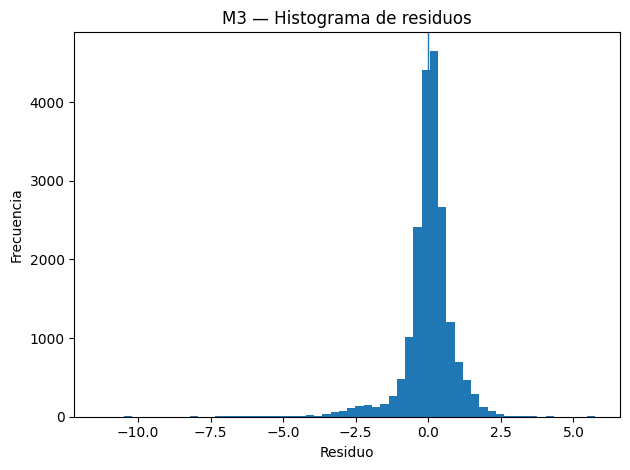

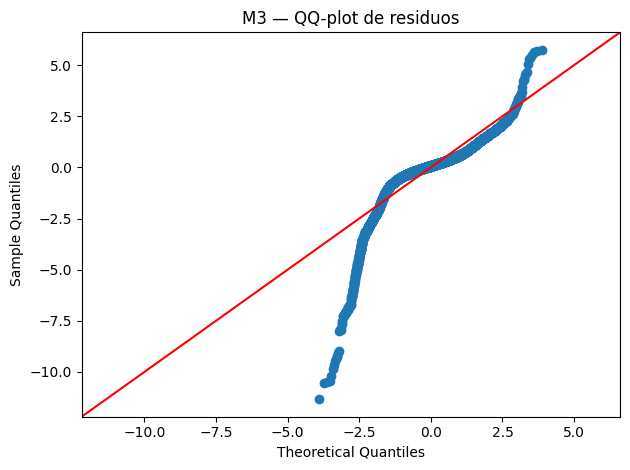

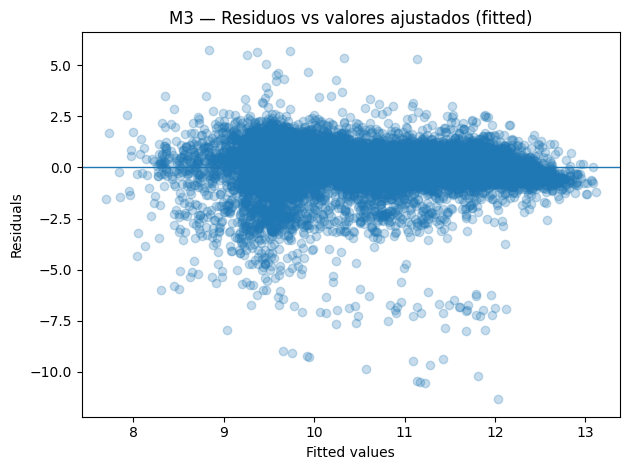

In [142]:
# === Diagnósticos visuales del modelo final (M3) ===
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

resid = m3.resid
fitted = m3.fittedvalues

# 1) Histograma de residuos
plt.figure()
plt.hist(resid, bins=60)
plt.axvline(0, linewidth=1)
plt.title("M3 — Histograma de residuos")
plt.xlabel("Residuo")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# 2) QQ-plot
fig = qqplot(resid, line="45")
plt.title("M3 — QQ-plot de residuos")
plt.tight_layout()
plt.show()

# 3) Residuos vs fitted
plt.figure()
plt.scatter(fitted, resid, alpha=0.25)
plt.axhline(0, linewidth=1)
plt.title("M3 — Residuos vs valores ajustados (fitted)")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()


## Interpretación de diagnósticos gráficos (M3) 


### 1) Histograma de residuos
El histograma muestra una masa principal centrada cerca de 0 (lo esperable si el modelo captura parte importante de la media condicional), pero con **colas pronunciadas**, especialmente una **cola izquierda considerablemente más extensa** (residuos negativos extremos). Esto sugiere casos puntuales de **sobrepredicción severa**: residuos negativos extremos implican observaciones para las cuales el modelo predice salarios muy superiores a los observados.

**Conexión con el análisis previo:** Este comportamiento es coherente con la evidencia formal previa (tests de heterocedasticidad) y con la presencia de observaciones potencialmente influyentes.

---

### 2) QQ-plot: desviación sistemática de normalidad (principalmente en colas)
El QQ-plot evidencia desviaciones fuertes respecto a la línea de referencia en ambas colas, con mayor severidad en la cola izquierda. La lectura técnica es:

- Los residuos **no se aproximan** a una distribución Normal, especialmente en los extremos.
- Esto indica **colas pesadas** (mayor probabilidad de errores grandes de lo que predeciría el supuesto normal).

**Implicación metodológica:** OLS puede seguir interpretándose como estimador de medias condicionales, pero la inferencia basada en supuestos clásicos (normalidad + homocedasticidad) puede ser poco confiable, en particular para pruebas de hipótesis con SE no robustos. Con tamaño muestral grande, la normalidad exacta no es un requisito para estimar la media condicional, pero sí refuerza la necesidad de una estrategia de inferencia robusta.

---

### 3) Residuos vs fitted: evidencia visual de heterocedasticidad y estructura no modelada
El gráfico de residuos vs valores ajustados muestra una dispersión que **no es uniforme** a lo largo del rango de fitted values, junto con la presencia de outliers relevantes. Esto es consistente con:

- **Heterocedasticidad**: la varianza condicional de los errores cambia con el nivel del salario predicho.
- **Posibles subestructuras no capturadas completamente**: aunque M3 incluye controles importantes y efectos fijos por país, la forma de la nube sugiere que existen factores adicionales que influyen en la dispersión (p.ej., industria, tipo/tamaño de empresa, costo de vida intra-país, formas no lineales).

**Conexión con el análisis previo:** el patrón visual respalda directamente los resultados de Breusch–Pagan y White (rechazo contundente de homocedasticidad) y justifica la adopción de errores estándar robustos **HC3**.

---

## Implicación directa para la RQ2
Estos diagnósticos impactan principalmente la **inferencialidad** (errores estándar, IC y tests), más que el signo del estimador:

1) **La estimación del efecto de modalidad en la media condicional** (coeficientes de Remote/Hybrid) sigue siendo interpretable como diferencia promedio ajustada bajo la especificación de M3.

2) **La incertidumbre asociada (SE, IC, p-values)** debe calcularse de forma robusta.  
   Dada la evidencia clara de heterocedasticidad y colas pesadas, reportar resultados con errores estándar clásicos podría llevar a:
   - intervalos de confianza demasiado estrechos,
   - significancia inflada,
   - conclusiones menos confiables.

3) **Qué se concluye sobre la RQ2 con estos diagnósticos:**  
   - Los gráficos refuerzan que la conclusión sobre si Remote/Hybrid difieren de In-person debe basarse en los **IC95% y p-values robustos (HC3)** del modelo final.  
   - Por tanto, la respuesta a la RQ2 debe formularse como una **asociación ajustada** (no causal) y apoyada en inferencia robusta.

En resumen: los diagnósticos confirman que el dataset y la especificación requieren inferencia robusta; en consecuencia, la comparación central de la RQ2 (Remote/Hybrid vs In-person) se reporta y evalúa usando **HC3**, preservando la validez de la conclusión estadística.


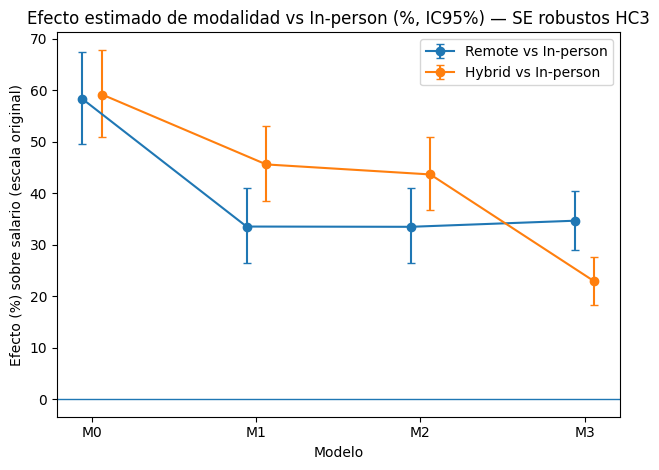

In [143]:
# === Visual final: Coefplot (efecto % e IC95% en HC3) a través de modelos M0–M3 ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

order = ["M0", "M1", "M2", "M3"]
models = {"M0": m0, "M1": m1, "M2": m2, "M3": m3}

def _contrast_label(term: str) -> str:
    if (RW_HYB in term) or ("T.Hybrid" in term) or ("Hybrid" in term):
        return "Hybrid vs In-person"
    if ("T.Remote" in term) or (f"T.{RW_REM}" in term):
        return "Remote vs In-person"
    return term

rows = []
for name, res in models.items():
    ef = remote_effects(res).copy()
    ef["term"] = ef.index
    ef["model"] = name
    ef["contrast"] = ef["term"].apply(_contrast_label)
    rows.append(ef.reset_index(drop=True))

plot_df = pd.concat(rows, ignore_index=True)
plot_df = plot_df[plot_df["contrast"].isin(["Remote vs In-person", "Hybrid vs In-person"])].copy()
plot_df["model"] = pd.Categorical(plot_df["model"], categories=order, ordered=True)
plot_df = plot_df.sort_values(["contrast", "model"])

plot_df["err_lo"] = plot_df["pct_effect"] - plot_df["ci_low_pct"]
plot_df["err_hi"] = plot_df["ci_high_pct"] - plot_df["pct_effect"]

x = np.arange(len(order))

plt.figure()
for contrast, offset in [("Remote vs In-person", -0.06), ("Hybrid vs In-person", 0.06)]:
    sub = plot_df[plot_df["contrast"] == contrast].set_index("model").reindex(order).reset_index()
    y = sub["pct_effect"].values
    yerr = np.vstack([sub["err_lo"].values, sub["err_hi"].values])
    plt.errorbar(x + offset, y, yerr=yerr, fmt="o-", capsize=3, label=contrast)

plt.axhline(0, linewidth=1)
plt.xticks(x, order)
plt.title("Efecto estimado de modalidad vs In-person (%, IC95%) — SE robustos HC3")
plt.xlabel("Modelo")
plt.ylabel("Efecto (%) sobre salario (escala original)")
plt.legend()
plt.tight_layout()
plt.show()


## Conclusiones y respuesta a RQ2

**RQ2:** ¿Las ofertas/modalidades de trabajo **Remote** y **Hybrid** están asociadas a salarios mayores que **In-person**?

Para responderlo se reporta el modelo final **M3**, que estima diferencias promedio condicionales en salario (en escala logarítmica) controlando por experiencia, educación, rol y país, con inferencia basada en errores estándar robustos **HC3**:

$
\log(\text{salary}) \sim \text{RemoteWork} + \text{YearsCodePro} + C(\text{EdLevel}) + C(\text{DevType}) + C(\text{Country})
$

### Hallazgos principales (M3, inferencia robusta HC3)
- **Remote vs In-person:** **+34.69%** (IC95%: **[29.08%, 40.54%]**, p = **7.13e-43**).  
  Interpretación: manteniendo constantes experiencia, educación, rol y país, la modalidad **Remote** se asocia con un salario significativamente mayor que **In-person**.

- **Hybrid vs In-person:** **+22.90%** (IC95%: **[18.36%, 27.61%]**, p = **6.4e-27**).  
  Interpretación: bajo los mismos controles, la modalidad **Hybrid** también se asocia con un salario significativamente mayor que **In-person**.

### Comparación con modelos más simples (robustez conceptual)
Los modelos menos controlados (M0–M2) muestran efectos más grandes, lo cual es consistente con **confusión** en la comparación cruda (diferencias de composición por experiencia, rol, educación y país). Aun así, los efectos permanecen **positivos y estadísticamente significativos** al llegar al modelo más exigente (M3), lo que refuerza que el resultado no es un artefacto de una especificación demasiado simple.

### Respuesta clara a la RQ2
**Sí.** En este dataset, y bajo el modelo final M3 con inferencia robusta HC3, las modalidades **Remote** y **Hybrid** están asociadas con **salarios mayores** que **In-person**, con efectos estimados de aproximadamente **+34.7%** (Remote) y **+22.9%** (Hybrid) respecto al grupo In-person.

### Alcance e interpretación
Estos resultados deben interpretarse como **asociaciones ajustadas** (diferencias promedio condicionales), **no** como efectos causales. Es posible que persista selección a remoto/híbrido y variables no observadas (p.ej., industria, tamaño de empresa, costo de vida intra-país). No obstante, la evidencia diagnóstica de heterocedasticidad y la presencia de leverage justifican el uso de **HC3**, lo que fortalece la confiabilidad de la inferencia reportada.
